## Basic LSTM

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Create timeseries data

tensor([0.0000, 0.1564, 0.3090, 0.4540, 0.5878, 0.7071, 0.8090, 0.8910, 0.9511,
        0.9877])


(-10.0, 801.0)

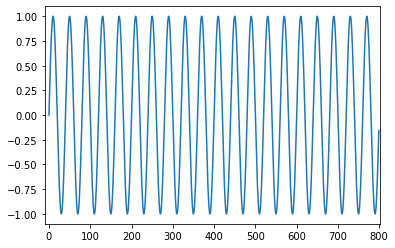

In [7]:
x = torch.linspace(0,799,800)
y = torch.sin(x*2*3.1416/40)
print(y[:10])
plt.plot(y)
plt.xlim(-10,801)

## Create train set

In [10]:
train_set = y[40:]

## Set up training batches

In [11]:
def input_data(seq, ws):

    out = [] #([0,1,2,3],[5])

    L = len(seq)

    for i in range(L-ws):

        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))   

    return out

## Plot training part

In [12]:
window_size = 40 
train_data = input_data(train_set, window_size)
print(train_data[0])
print(len(train_data))

(tensor([ 1.4480e-05,  1.5645e-01,  3.0903e-01,  4.5400e-01,  5.8780e-01,
         7.0712e-01,  8.0903e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5105e-01,  8.9100e-01,  8.0901e-01,
         7.0709e-01,  5.8777e-01,  4.5397e-01,  3.0900e-01,  1.5641e-01,
        -2.1005e-05, -1.5646e-01, -3.0904e-01, -4.5401e-01, -5.8780e-01,
        -7.0712e-01, -8.0903e-01, -8.9102e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8768e-01, -9.5105e-01, -8.9099e-01, -8.0900e-01,
        -7.0709e-01, -5.8776e-01, -4.5397e-01, -3.0899e-01, -1.5641e-01]), tensor([2.8960e-05]))
720


### Create training_data

In [13]:
window_size = 40 
train_data = input_data(train_set, window_size)
print(train_data[0])
print(len(train_data))

(tensor([ 1.4480e-05,  1.5645e-01,  3.0903e-01,  4.5400e-01,  5.8780e-01,
         7.0712e-01,  8.0903e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5105e-01,  8.9100e-01,  8.0901e-01,
         7.0709e-01,  5.8777e-01,  4.5397e-01,  3.0900e-01,  1.5641e-01,
        -2.1005e-05, -1.5646e-01, -3.0904e-01, -4.5401e-01, -5.8780e-01,
        -7.0712e-01, -8.0903e-01, -8.9102e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8768e-01, -9.5105e-01, -8.9099e-01, -8.0900e-01,
        -7.0709e-01, -5.8776e-01, -4.5397e-01, -3.0899e-01, -1.5641e-01]), tensor([2.8960e-05]))
720


## Create LSTM

In [14]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_size=50, out_size=1):

        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size) # Create a layer of 50 neurons

        self.linear = nn.Linear(hidden_size, out_size)  # Condence back to 1 layer

        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)

        pred = self.linear(lstm_out.view(len(seq),-1))

        return pred[-1] # Only grab the last value 



In [15]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [16]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


## Predict future values

Epoch 0 Loss: 0.09213081002235413
Performance on test range: 0.6071493029594421


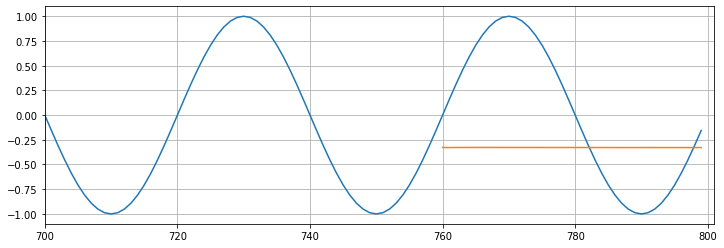

Epoch 1 Loss: 0.06506868451833725
Performance on test range: 0.5650901794433594


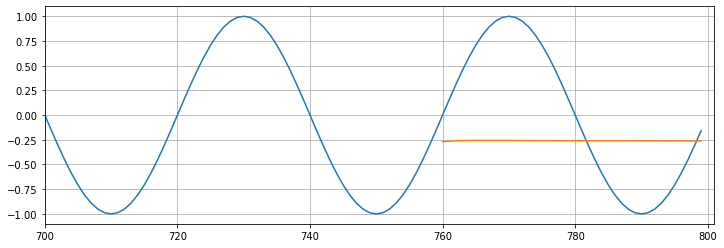

Epoch 2 Loss: 0.0419810451567173
Performance on test range: 0.5199652314186096


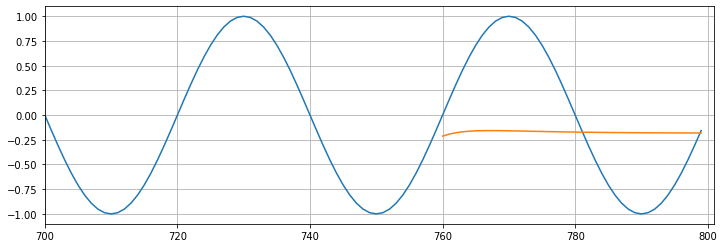

Epoch 3 Loss: 0.01784287951886654
Performance on test range: 0.42209625244140625


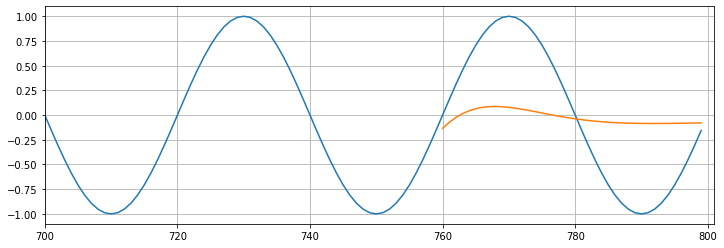

Epoch 4 Loss: 0.0028870084788650274
Performance on test range: 0.16624465584754944


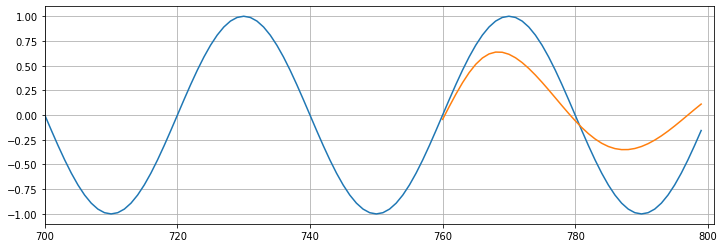

Epoch 5 Loss: 0.0003200198116246611
Performance on test range: 0.03055775724351406


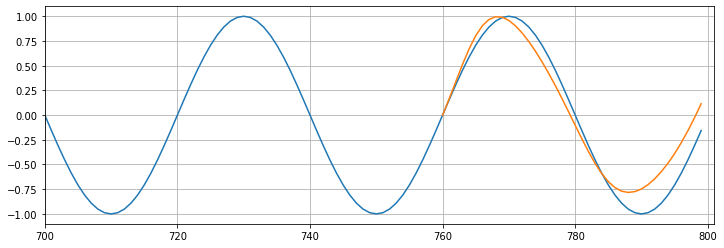

Epoch 6 Loss: 0.0001296523550990969
Performance on test range: 0.01499265618622303


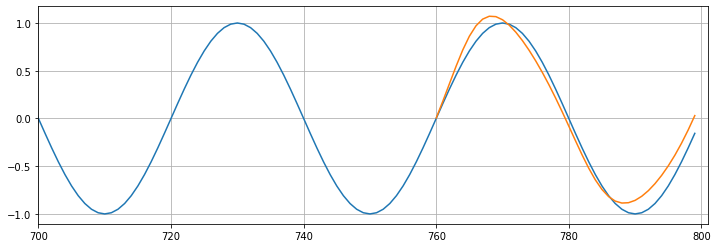

Epoch 7 Loss: 0.00012002978473901749
Performance on test range: 0.01185897458344698


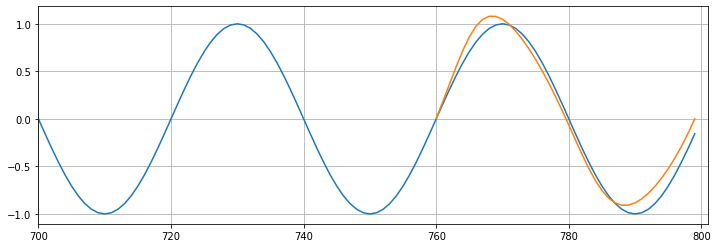

Epoch 8 Loss: 0.00012651934230234474
Performance on test range: 0.010165872052311897


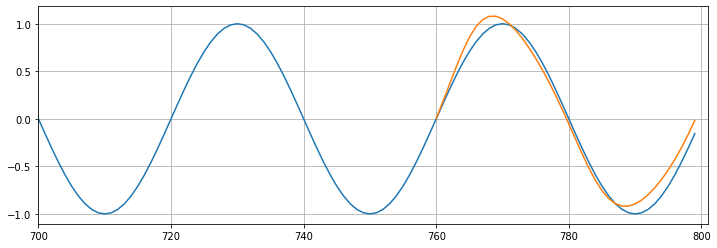

Epoch 9 Loss: 0.00013191676407586783
Performance on test range: 0.008899534121155739


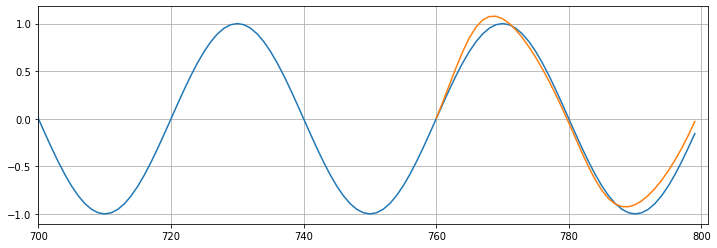

In [17]:
epochs = 10
future = 40 

for i in range(epochs):

    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} Loss: {loss.item()}")
    preds = train_set[-window_size:].tolist()

    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])

        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))

            preds.append(model(seq).item())
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f"Performance on test range: {loss}")

    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y)
    plt.plot(range(760, 800), preds[window_size:])
    plt.show()

# Tryout med tensor shape (40,2)

In [53]:
# 
seq = torch.zeros([2,40])

In [54]:
for seq0, y_train in train_data:
    break

In [60]:
seq[0] = seq0
seq[1] = seq0
seq.shape

torch.Size([2, 40])

In [59]:
seq.shape

torch.Size([2, 40])

### Build a model that accept 2x40 dim

In [25]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_size=50, out_size=1):

        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size) # Create a layer of 50 neurons

        self.linear = nn.Linear(hidden_size, out_size)  # Condence back to 1 layer

        self.hidden = (torch.zeros(1,1, hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)

        #pred = self.linear(lstm_out.view(len(seq),-1))

        #return pred[-1] # Only grab the last value 



In [ ]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
epochs = 10
future = 40 

for i in range(epochs):

    for seq, y_train in train_data:
        seq = seq.reshape(80,1)
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch {i} Loss: {loss.item()}")
    preds = train_set[-window_size:].tolist()

    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])

        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))

            preds.append(model(seq).item())
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f"Performance on test range: {loss}")

    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y)
    plt.plot(range(760, 800), preds[window_size:])
    plt.show()